Tests that I want to run include:
* Checking if the construct is unidimensional a the macro level (sum indicator) level
* Examining the indicators to see if each sub indicator is uni-dimensional
* Seeing what happens to the distribution/number of communities included if we move to a %Population based scoring system. 

In [19]:
library(tidyverse)
library(psych)

In [2]:
score_files = list.files("../data/score/csv/full", full.names = TRUE)
usa = read_csv(score_files[grepl("usa.csv", score_files)]) # read in the data


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  GEOID10_TRACT = col_character(),
  `Does the tract have at least 35 acres in it?` = col_logical(),
  `Contains agricultural value` = col_logical(),
  `Names of Tribal areas within Census tract` = col_character(),
  `Percent individuals age 25 or over with less than high school degree in 2009` = col_logical(),
  `Percentage households below 100% of federal poverty line in 2009` = col_logical(),
  `Unemployment (percent) in 2009` = col_logical(),
  `Total population in 2009` = col_logical(),
  `Number of Tribal areas within Census tract for Alaska` = col_logical(),
  `Number of Tribal areas within Census tract` = col_logical(),
  `Median household income as a percent of territory median income in 2009` = col_logical(),
  `Is there at least one abandoned mine in this census tract?` = col_logical(),
  `Income data has been estimated based on neighbor income` = col_logical(),

In [3]:
head(usa) ## take a quick look to make sure its in the right format

GEOID10_TRACT,Does the tract have at least 35 acres in it?,Contains agricultural value,Names of Tribal areas within Census tract,Housing burden (percent),Share of homes with no kitchen or indoor plumbing (percent),Total population,Median household income (% of state median household income),Current asthma among adults aged greater than or equal to 18 years,Coronary heart disease among adults aged greater than or equal to 18 years,⋯,Workforce Factor (Definition N),Total categories exceeded,Definition N (communities),Definition N (communities) (percentile),Meets the less stringent low income criterion for the adjacency index?,Definition N (communities) (average of neighbors),Is the tract surrounded by disadvantaged communities?,Definition N (communities) (based on adjacency index and low income alone),"Definition N community, including adjacency index tracts",Percentage of tract that is disadvantaged
<chr>,<lgl>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<lgl>,<dbl>,<lgl>,<dbl>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<dbl>
01073001100,TRUE,TRUE,NA,0.2752044,0.000000000,4781,0.7327450,11.2,7.2,⋯,FALSE,0,FALSE,0,TRUE,0.8571429,FALSE,FALSE,FALSE,0
01073001400,TRUE,TRUE,NA,0.1823529,0.004705882,1946,0.7136695,11.1,9.1,⋯,TRUE,6,TRUE,1,TRUE,1.0000000,TRUE,TRUE,TRUE,1
01073002000,TRUE,TRUE,NA,0.4350877,0.006872852,4080,0.5374189,13.5,9.5,⋯,TRUE,3,TRUE,1,TRUE,1.0000000,TRUE,TRUE,TRUE,1
01073003802,TRUE,TRUE,NA,0.4111406,0.038961039,5291,0.7662063,12.0,6.6,⋯,FALSE,4,TRUE,1,TRUE,1.0000000,TRUE,TRUE,TRUE,1
01073004000,TRUE,FALSE,NA,0.4683099,0.009900990,2533,0.3665704,13.1,10.0,⋯,TRUE,5,TRUE,1,TRUE,1.0000000,TRUE,TRUE,TRUE,1
01073005101,TRUE,FALSE,NA,0.5264000,0.000000000,1467,0.3133014,15.2,11.6,⋯,TRUE,6,TRUE,1,TRUE,1.0000000,TRUE,TRUE,TRUE,1


In [4]:
usa %>% select(contains("Factor")) %>% colnames

[1] "Climate Factor (Definition N)"       
[2] "Energy Factor (Definition N)"        
[3] "Transportation Factor (Definition N)"
[4] "Housing Factor (Definition N)"       
[5] "Pollution Factor (Definition N)"     
[6] "Water Factor (Definition N)"         
[7] "Health Factor (Definition N)"        
[8] "Workforce Factor (Definition N)"

First thing that I want to do is explore just the aggregate level metrics. They are already put into groups and that is super helpful

In [82]:
macro_factors <- usa %>% 
select(contains("Factor"), GEOID10_TRACT, pop =  `Total population`) %>% 
rename_with(.cols = everything()
            , .fn = ~str_replace_all(str_trim(str_replace_all(.x, "\\(Definition N\\)", "")), " ", "_")) %>%
mutate(across(contains("Factor"), as.numeric)) %>%
rowwise(GEOID10_TRACT) %>%
mutate(total = sum(c_across(contains("Factor")))) %>%
ungroup()

head(macro_factors)

Climate_Factor,Energy_Factor,Transportation_Factor,Housing_Factor,Pollution_Factor,Water_Factor,Health_Factor,Workforce_Factor,GEOID10_TRACT,pop,total
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
0,0,0,0,0,0,0,0,01073001100,4781,0
1,1,1,1,0,0,1,1,01073001400,1946,6
0,1,0,0,0,0,1,1,01073002000,4080,3
1,1,0,1,0,0,1,0,01073003802,5291,4
1,1,0,1,0,0,1,1,01073004000,2533,5
1,1,1,1,0,0,1,1,01073005101,1467,6


First, we run tetrachoric correlations to see which factors correlate well with other factors. (Tetrachoric correlations are designed for binary factors. They make the assumption that the binary factor is based off of a normal distribution that has been binned. this is a really fair assumption for this data because that is similar to what happened).

In [10]:
tetra_cor <- macro_factors %>% select(contains("Factor")) %>% tetrachoric
tetra_cor

Call: tetrachoric(x = .)
tetrachoric correlation 
                      Clm_F Enr_F Trn_F Hsn_F Pll_F Wtr_F Hlt_F Wrk_F
Climate_Factor        1.00                                           
Energy_Factor         0.50  1.00                                     
Transportation_Factor 0.49  0.57  1.00                               
Housing_Factor        0.37  0.71  0.67  1.00                         
Pollution_Factor      0.42  0.60  0.63  0.75  1.00                   
Water_Factor          0.30  0.46  0.61  0.73  0.65  1.00             
Health_Factor         0.60  0.72  0.57  0.69  0.57  0.53  1.00       
Workforce_Factor      0.40  0.71  0.59  0.78  0.67  0.64  0.68  1.00 

 with tau of 
       Climate_Factor         Energy_Factor Transportation_Factor 
                 1.14                  1.20                  1.19 
       Housing_Factor      Pollution_Factor          Water_Factor 
                 1.00                  1.16                  1.46 
        Health_Factor      Workforce_

* Climate has moderate correlations with all of them
* Energy has some stronger, positive coincidence with housing, health, and workforce (>.7)
* Traffice has pretty strong coincidence with pollution, water, and workforce (> .6)
* Housing is pretty strongly related with water and workforce (.75) and to health (.69), also to transportation and pollution.  
* Pollution has stronger connections to traffic, housing, water, and workforce (.7)
* Water has strong linkages to housing (.73) and workforce (.47) and moderate linkage to health (.46)
* Workforce is intertwined with Energy (.71),  housing (.78) and water & health (.6) and Pollution (.67)

We run a scree plot of the tetrachoric correlations. The scree plot shows hows how much of the variance is explained in different levels of factor models. We really care about the lower (hollow) line more than the principal components line. This suggests that two factors at most are probably sufficient. Although, it could be convincingly unidimensional. 

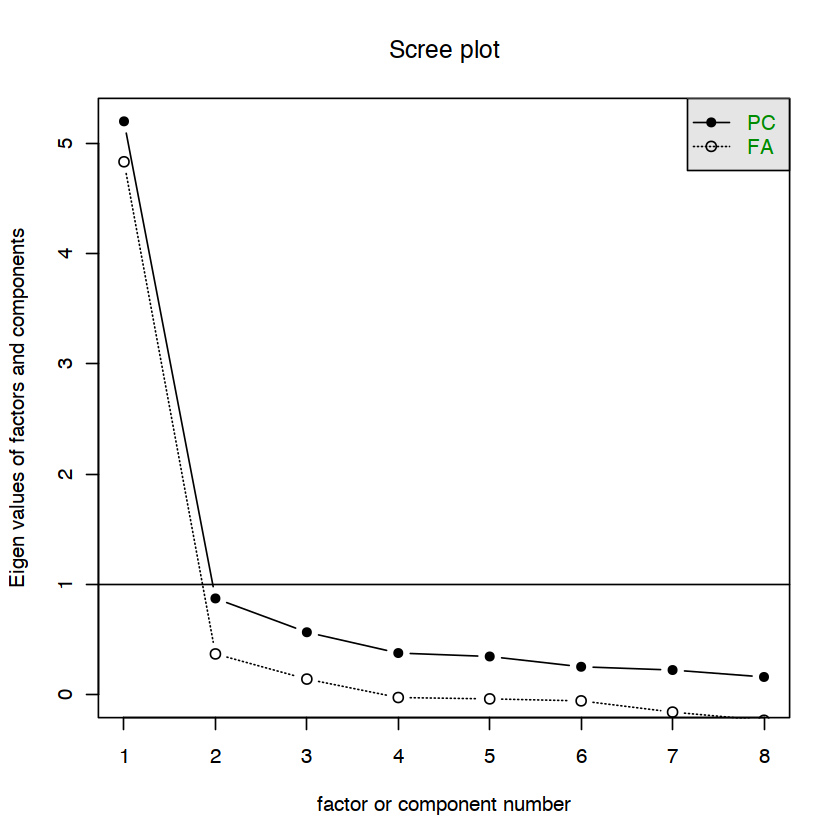

In [11]:
scree(tetra_cor[[1]])

After running the scree plot, we start to run some factor models to interrogate what is actually happening here. For all of these, I use (a) a tetrachoric correlation measure, (b) allow rotation of factors (hint, check for factor correlations) and (c) try both weighted least squares and maximum likelihood solutions for robustness

In [13]:
factor_names <- names(macro_factors)[grepl("Factor", names(macro_factors))]

In [14]:
faOut1ProWls <- fa(macro_factors[, factor_names], nfactors = 1, cor = "tet",  rotate="promax", fm="wls", SMC=TRUE)
print(faOut1ProWls, sort=TRUE)

faOut1ProMl <- fa(macro_factors[, factor_names], nfactors = 1, cor = "tet",  rotate="promax", fm="ml", SMC=TRUE)
print(faOut1ProMl, sort=TRUE)


Factor Analysis using method =  wls
Call: fa(r = macro_factors[, factor_names], nfactors = 1, rotate = "promax", 
    SMC = TRUE, fm = "wls", cor = "tet")
Standardized loadings (pattern matrix) based upon correlation matrix
                      V WLS1   h2   u2 com
Housing_Factor        4 0.90 0.81 0.19   1
Workforce_Factor      8 0.85 0.72 0.28   1
Pollution_Factor      5 0.80 0.64 0.36   1
Health_Factor         7 0.80 0.64 0.36   1
Energy_Factor         2 0.79 0.63 0.37   1
Transportation_Factor 3 0.75 0.57 0.43   1
Water_Factor          6 0.73 0.54 0.46   1
Climate_Factor        1 0.54 0.30 0.70   1

               WLS1
SS loadings    4.83
Proportion Var 0.60

Mean item complexity =  1
Test of the hypothesis that 1 factor is sufficient.

The degrees of freedom for the null model are  28  and the objective function was  5.79 with Chi Square of  429470
The degrees of freedom for the model are 20  and the objective function was  0.64 

The root mean square of the residuals (RMSR) is 

The results for the unifactor analysis are promising. It is pretty clear that the climate factor does not vary in the same way as the other factors. The RMSEA is higher than we'd want. So we don't think these results support a conclusion of unidimensionality.

In [15]:
faOut2ProWls <- fa(macro_factors[, factor_names], nfactors = 2, cor = "tet",  rotate="promax", fm="wls", SMC=TRUE)
print(faOut2ProWls, sort=TRUE)

faOut2ProMl <- fa(macro_factors[, factor_names], nfactors = 2, cor = "tet",  rotate="promax", fm="ml", SMC=TRUE)
print(faOut2ProMl, sort=TRUE)


Loading required namespace: GPArotation



Factor Analysis using method =  wls
Call: fa(r = macro_factors[, factor_names], nfactors = 2, rotate = "promax", 
    SMC = TRUE, fm = "wls", cor = "tet")
Standardized loadings (pattern matrix) based upon correlation matrix
                      item  WLS1  WLS2   h2   u2 com
Housing_Factor           4  0.98 -0.05 0.89 0.11 1.0
Water_Factor             6  0.90 -0.16 0.63 0.37 1.1
Pollution_Factor         5  0.76  0.07 0.65 0.35 1.0
Workforce_Factor         8  0.71  0.17 0.71 0.29 1.1
Transportation_Factor    3  0.55  0.25 0.56 0.44 1.4
Climate_Factor           1 -0.18  0.87 0.56 0.44 1.1
Health_Factor            7  0.24  0.67 0.74 0.26 1.3
Energy_Factor            2  0.36  0.52 0.66 0.34 1.8

                      WLS1 WLS2
SS loadings           3.60 1.81
Proportion Var        0.45 0.23
Cumulative Var        0.45 0.68
Proportion Explained  0.67 0.33
Cumulative Proportion 0.67 1.00

 With factor correlations of 
     WLS1 WLS2
WLS1 1.00 0.72
WLS2 0.72 1.00

Mean item complexity =  1.2
T

Climate health and energy as a separate, but correlated factor is really interesting here. 

In [17]:
faOut3ProWls <- fa(macro_factors[, factor_names], nfactors = 3, cor = "tet",  rotate="promax", fm="wls", SMC=TRUE)
print(faOut3ProWls, sort=TRUE)

faOut3ProMl <- fa(macro_factors[, factor_names], nfactors = 3, cor = "tet",  rotate="promax", fm="ml", SMC=TRUE)
print(faOut3ProMl, sort=TRUE)


Factor Analysis using method =  wls
Call: fa(r = macro_factors[, factor_names], nfactors = 3, rotate = "promax", 
    SMC = TRUE, fm = "wls", cor = "tet")
Standardized loadings (pattern matrix) based upon correlation matrix
                      item  WLS1  WLS3  WLS2   h2     u2 com
Water_Factor             6  1.00 -0.18 -0.03 0.72 0.2827 1.1
Pollution_Factor         5  0.69  0.13  0.03 0.66 0.3361 1.1
Housing_Factor           4  0.66  0.39 -0.15 0.87 0.1343 1.8
Transportation_Factor    3  0.60  0.07  0.19 0.58 0.4155 1.2
Energy_Factor            2 -0.11  0.98  0.00 0.81 0.1905 1.0
Health_Factor            7  0.12  0.61  0.20 0.70 0.3022 1.3
Workforce_Factor         8  0.41  0.54 -0.09 0.73 0.2713 1.9
Climate_Factor           1 -0.03  0.01  1.01 1.00 0.0034 1.0

                      WLS1 WLS3 WLS2
SS loadings           2.76 2.18 1.13
Proportion Var        0.35 0.27 0.14
Cumulative Var        0.35 0.62 0.76
Proportion Explained  0.46 0.36 0.19
Cumulative Proportion 0.46 0.81 1.00

 W

This is explaining 76% of the variance which is really fascinating. It is pretty clear that climate is just a different dimension than the others. But it has a heywood type of behavior (loading > 1) which is suspect. 

We've analyzed how the indicators relate to eachother. Now we want to see, if we force them to be unidimensional, how do they relate to a potential sum score?

In [75]:
biserial_cor <- map_df(factor_names,
~tibble(
 var = .x
, cor =  cor.test( pull(macro_factors, !!.x), pull(macro_factors, total))$estimate[[1]]
)) %>%
arrange(desc(cor))

biserial_cor



var,cor
<chr>,<dbl>
Housing_Factor,0.7517154
Workforce_Factor,0.7285986
Health_Factor,0.7037795
Pollution_Factor,0.6610811
Energy_Factor,0.6589622
Transportation_Factor,0.6237871
Water_Factor,0.5479080
Climate_Factor,0.5001500


The result here is honestly very promising. Again, we see that scoring a point on the climate burden isn't as predictive of scoring higher points overall. But we see that the other indicators really do cling together

What does this look like in practice? Can we see if there are overall contrasts on sum score between answering yes and no on other scores? If you get one, do you usually get others? These tables have the contrast as well as the percent with sum scores above 6

In [76]:
yes_no_averages <- map_df( factor_names,
~macro_factors %>% 
    group_by(group = !!sym(.x) ) %>% 
    mutate(six = total >= 5) %>%
    summarise(
        total = mean(total)
      , count = n()
      , six = mean(as.numeric(six))
             ) %>%
    mutate(indicator = !!.x)
)

yes_no_averages %>%
select(group, total, indicator) %>%
spread(group, total) %>%
mutate(contrast = `1` - `0`,
      pct_contrast = contrast/`0`) %>%
arrange(desc(pct_contrast)) %>%
rename(
`Average Total Score for\nNo's on this Indicator` = '0' 
, `Average Total Score for\nYes's on this Indicator` = '1' 

)


yes_no_averages %>%
select(group, six, indicator) %>%
spread(group, six) %>%
mutate(contrast = `1` - `0`,
      pct_contrast = contrast/`1`) %>%
rename(
`% with total above 6 for\nNo's on this Indicator` = '0' 
, `% with no's above 6 for\nYes's on this Indicator` = '1' 
) %>%
arrange(desc(contrast))


indicator,Average Total Score for No's on this Indicator,Average Total Score for Yes's on this Indicator,contrast,pct_contrast
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Workforce_Factor,0.4319225,3.618270,3.186347,7.377127
Housing_Factor,0.5139329,4.164642,3.650710,7.103475
Health_Factor,0.5189483,3.808661,3.289713,6.339192
Pollution_Factor,0.6510254,4.211056,3.560031,5.468344
Energy_Factor,0.6709811,4.338887,3.667906,5.466482
Transportation_Factor,0.6891409,4.133264,3.444123,4.997705
Water_Factor,0.8192801,4.567876,3.748596,4.575475
Climate_Factor,0.7532111,3.418893,2.665682,3.539090


indicator,% with total above 6 for No's on this Indicator,% with no's above 6 for Yes's on this Indicator,contrast,pct_contrast
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Water_Factor,0.041113017,0.5635752,0.5224622,0.9270496
Energy_Factor,0.028323004,0.4705187,0.4421957,0.9398047
Pollution_Factor,0.024861921,0.4626163,0.4377544,0.9462580
Housing_Factor,0.011002210,0.4408998,0.4298976,0.9750460
Transportation_Factor,0.031093540,0.4413129,0.4102194,0.9295431
Workforce_Factor,0.006850246,0.3553973,0.3485470,0.9807251
Health_Factor,0.024986943,0.3351734,0.3101864,0.9254507
Climate_Factor,0.053785353,0.2519769,0.1981916,0.7865465


Above is another way to show a very similar thing. 

We also want to check the distribution of this score across communities

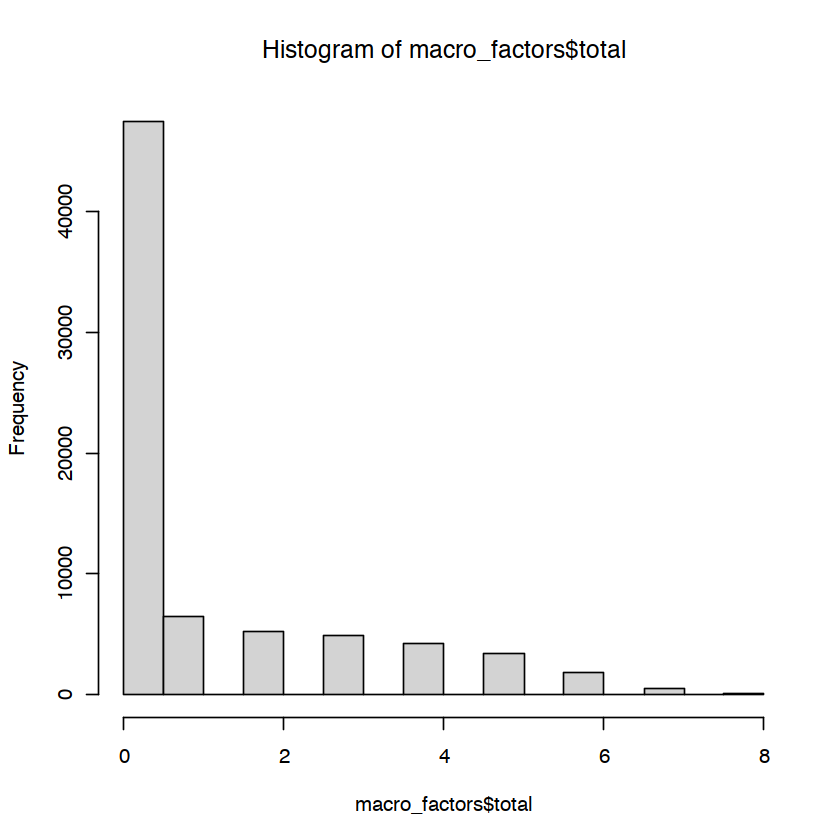

In [77]:
hist(macro_factors$total)

In [84]:
## need to edit this to get a more population-focused analysis. 
macro_factors %>% 
group_by(total) %>% 
summarise(count = n(), pop = sum(pop, na.rm = TRUE)) %>%
ungroup() %>%
mutate(
      pct = count/sum(count)
    , cumpct = cumsum(pct)
    , pct_pop = pop/sum(pop)
    , cumpct_pop = cumsum(pct_pop)
) %>%
arrange(desc(total)) %>%
mutate(
    under_sum = cumsum(pct)
   , under_sumpop = cumsum(pct_pop)

)

total,count,pop,pct,cumpct,pct_pop,cumpct_pop,under_sum,under_sumpop
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8,65,163983,0.0008767907,1.0000000,0.0004995405,1.0000000,0.0008767907,0.0004995405
7,525,1673274,0.0070817708,0.9991232,0.0050972848,0.9995005,0.0079585615,0.0055968252
6,1835,6315784,0.0247524752,0.9920414,0.0192397358,0.9944032,0.0327110368,0.0248365611
5,3417,12174680,0.0460922114,0.9672890,0.0370876564,0.9751634,0.0788032482,0.0619242175
4,4227,15900433,0.0570183721,0.9211968,0.0484373960,0.9380758,0.1358216203,0.1103616134
3,4874,19303789,0.0657458116,0.8641784,0.0588050194,0.8896384,0.2015674319,0.1691666328
2,5235,21922736,0.0706153722,0.7984326,0.0667831023,0.8308334,0.2721828041,0.2359497352
1,6494,29459396,0.0875981331,0.7278172,0.0897419856,0.7640503,0.3597809372,0.3256917207
0,47462,221353634,0.6402190628,0.6402191,0.6743082793,0.6743083,1.0000000000,1.0000000000


Where do we go from here?

What is the purpose of investigating multiple impacts? J40 doesn't have a mechanism for prioritizing "more disadvantaged" communities. So we don't necessarily need to just add the components. 

Is the problem we are trying to solve the issue of multiple disadvantages but that are less than one of the thresholds? Is the issue that they aren't low income? Do we remove that from the consideration? Is the issue that each indicator is thresholded? Do we want to just add up all of those indicators to make a macro level indicator? Do we include 